In [1]:
!pip install sme

In [2]:
import sme
from matplotlib import pyplot as plt
import matplotlib.cm as cm

####  Importing a model
- to load an existing model: `sme.open_sbml_file('model_filename.xml')`
- to load a built-in example model: `sme.open_example_model()`

In [3]:
my_model = sme.open_example_model()

####  Getting help
- to see the type of an object: `type(object)`
- to print a one line description of an object: `repr(object)`
- to print a multi-line description of an object: `print(object)`
- to get help on an object, its methods and properties: `help(object)`

In [4]:
type(my_model)

sme.Model

In [5]:
repr(my_model)

"<sme.Model named 'Very Simple Model'>"

In [6]:
print(my_model)

<sme.Model>
  - name: 'Very Simple Model'
  - compartments:
     - Outside
     - Cell
     - Nucleus


In [7]:
help(my_model)

Help on Model in module sme object:

class Model(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      Model
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(self: sme.Model, filename: str) -> None
 |  
 |  __repr__(...)
 |      __repr__(self: sme.Model) -> str
 |  
 |  __str__(...)
 |      __str__(self: sme.Model) -> str
 |  
 |  compartment(...)
 |      compartment(self: sme.Model, name: str) -> sme::Compartment
 |  
 |  export_sbml_file(...)
 |      export_sbml_file(self: sme.Model, filename: str) -> None
 |  
 |  parameter(...)
 |      parameter(self: sme.Model, name: str) -> sme::Parameter
 |  
 |  simulate(...)
 |      simulate(self: sme.Model, simulation_time: float, image_interval: float) -> List[sme::SimulationResult]
 |  
 |  ----------------------------------------------------------------------
 |  Readonly properties defined here:
 |  
 |  compartment_image
 |  
 |  com

####  Model contents
- the compartments in a model can be accessed as a list: `model.compartments`
- or a compartment can be looked up using its name: `model.compartment('compartment name')`
- other objects, such as species in a compartment, or parameters in a reaction, can be accessed in the same way

In [8]:
type(my_model.compartments)

list

In [9]:
print(my_model.compartments)

[<sme.Compartment named 'Outside'>, <sme.Compartment named 'Cell'>, <sme.Compartment named 'Nucleus'>]


In [10]:
my_compartment = my_model.compartment('Cell')
type(my_compartment)

sme.Compartment

In [11]:
print(my_compartment)

<sme.Compartment>
  - name: 'Cell'
  - species: 
     - A_cell
     - B_cell


In [12]:
for compartment in my_model.compartments:
    print(compartment)

<sme.Compartment>
  - name: 'Outside'
  - species: 
     - A_out
     - B_out
<sme.Compartment>
  - name: 'Cell'
  - species: 
     - A_cell
     - B_cell
<sme.Compartment>
  - name: 'Nucleus'
  - species: 
     - A_nucl
     - B_nucl


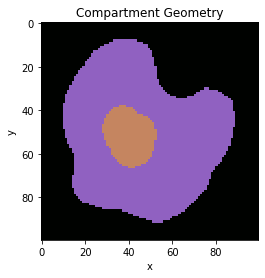

In [13]:
compartment_img = my_model.compartment_image

plt.title("Compartment Geometry")
plt.xlabel("x")
plt.ylabel("y")
plt.imshow(compartment_img, interpolation='none')
plt.show()

In [14]:
my_reac = my_model.compartment('Nucleus').reaction('A to B conversion')
print(my_reac)
for param in my_reac.parameters:
    print(param)

<sme.Reaction>
  - name: 'A to B conversion'

<sme.ReactionParameter>
  - name: 'k1'
  - value: '0.3'



####  Editing model parameters
- model parameters can be changed by assigning new values to them

In [15]:
print(my_model.name)

Very Simple Model


In [16]:
my_model.name = 'New model name!'

In [17]:
print(my_model.name)

New model name!


####  Simulation
- models can be simulated by specifying the total simulation time, and the interval between images
- the simulation returns a list of `SimulationResult` objects, each of which contains
  - `time_point`: the time point
  - `concentration_image`: an image of the species concentrations at this time point
  - `species_concentration`: a dict of the concentrations for each species at this time point

In [18]:
sim_results = my_model.simulate(simulation_time=250.0, image_interval=50.0)
type(sim_results[0])
print(sim_results[0])

<sme.SimulationResult>
  - timepoint: '0.0'
  - number of species: 5



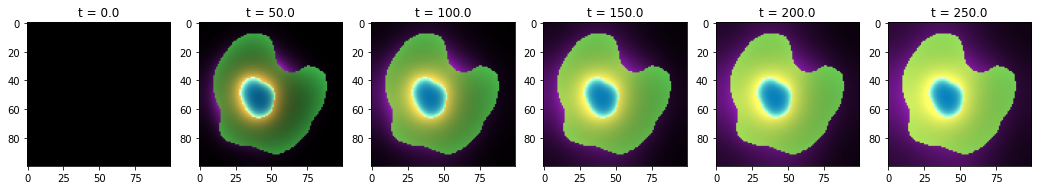

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=len(sim_results), figsize=(18, 12))
for (ax, res) in zip(axs, sim_results):
    ax.imshow(res.concentration_image)
    ax.set_title(f"t = {res.time_point}")
plt.show()

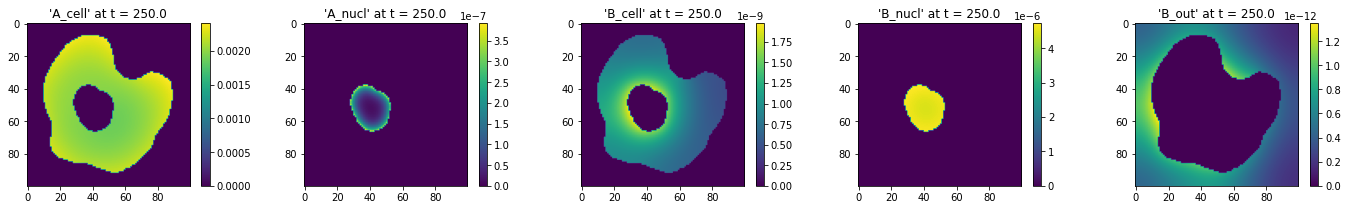

In [20]:
result = sim_results[5]
fig, axs = plt.subplots(nrows=1, ncols=len(result.species_concentration), figsize=(24, 3))
for (ax, (species, concentration)) in zip(axs, result.species_concentration.items()):
    im = ax.imshow(concentration)
    ax.set_title(f"'{species}' at t = {result.time_point}")
    fig.colorbar(im, ax=ax)
plt.show()

####  Reaction rate example

Here we repeat a simulation four times, each time with a different value for the `k1` parameter in the `A to B conversion` reaction within the Nucleus, and plot the resulting species concentrations at `t=25`

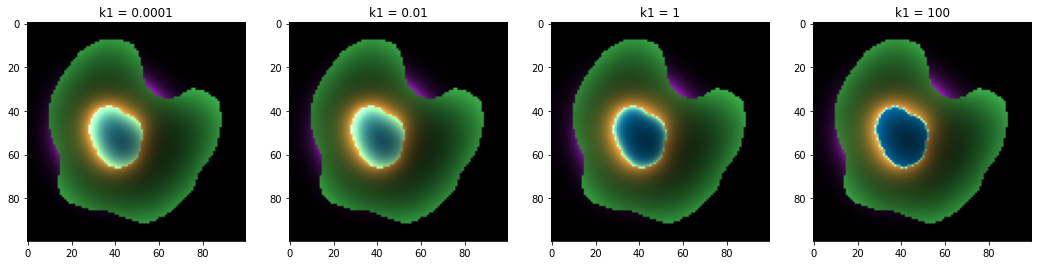

In [21]:
k1vals = [1e-4, 1e-2, 1, 100]
fig, axs = plt.subplots(nrows=1, ncols=len(k1vals), figsize=(18, 12))
for ax, k1 in zip(axs, k1vals):
    my_model.compartment('Nucleus').reaction('A to B conversion').parameter('k1').value = k1
    results = my_model.simulate(simulation_time=25.0, image_interval=25.0)
    ax.imshow(results[1].concentration_image)
    ax.set_title(f"k1 = {k1}")
plt.show()

####  Diffusion constant example

Here we repeat a simulation four times, each time with a different value for the diffusion constant of species `B_cell`, and plot the resulting concentration of this species at `t=15`.

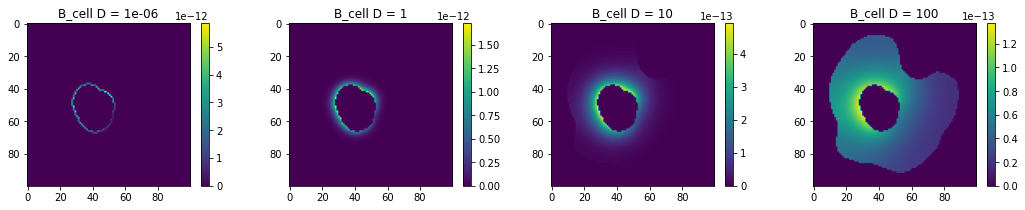

In [22]:
diffconsts = [1e-6, 1, 10, 100]
fig, axs = plt.subplots(nrows=1, ncols=len(diffconsts), figsize=(18, 3))
for ax, diffconst in zip(axs, diffconsts):
    my_model.compartment('Cell').specie('B_cell').diffusion_constant = diffconst
    results = my_model.simulate(simulation_time=15.0, image_interval=15.0)
    im = ax.imshow(results[1].species_concentration['B_cell'])
    ax.set_title(f"B_cell D = {diffconst}")
    fig.colorbar(im, ax=ax)
plt.show()